In [58]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from keras.regularizers import l2
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Data

In [2]:
# Get all preprocessed datasets
train_df = pd.read_csv('preprocessed_train.csv')
test_df = pd.read_csv('preprocessed_test.csv')
val_df = pd.read_csv('preprocessed_val.csv')

In [3]:
train_df.head()

,text,sentiment
0,fuck bayless isoing,anger
1,make feel threatened,fear
2,dirty southern wanker,anger
3,omg peyton good enough help u playoff dumbass ...,surprise
4,need board create bit space name we’ll good,joy


In [4]:
test_df.head()

,text,sentiment
0,i’m really sorry situation although love name ...,sadness
1,king fan here good luck guy interesting game w...,joy
2,i’m sorry hear friend it’s best likely didn’t ...,sadness
3,girlfriend weak well jump pathetic,sadness
4,name towed line dark side cross something like...,anger


In [5]:
val_df.head()

,text,sentiment
0,i ve never sad life,sadness
1,could easily taken real camera legitimate sour...,joy
2,wah mum people call bullshit can t ban go side...,anger
3,least name time gain confidence,joy
4,good want thrash liberal offspring world,anger


In [6]:
# Check to make sure the types of text values are str
print(train_df['text'].apply(type).value_counts())

text
<class 'str'>      22829
<class 'float'>        2
Name: count, dtype: int64


In [7]:
# convert float type text to str type - Train
train_df = train_df[train_df['text'].apply(type) != float]
train_df.reset_index(drop=True, inplace=True)
print(train_df['text'].apply(type).value_counts())

text
<class 'str'>    22829
Name: count, dtype: int64


In [8]:
# convert float type text to str type - Test
test_df = test_df[test_df['text'].apply(type) != float]
test_df.reset_index(drop=True, inplace=True)
print(test_df['text'].apply(type).value_counts())

text
<class 'str'>    2859
Name: count, dtype: int64


In [9]:
# convert float type text to str type - Validation
val_df = val_df[val_df['text'].apply(type) != float]
val_df.reset_index(drop=True, inplace=True)
print(val_df['text'].apply(type).value_counts())

text
<class 'str'>    2852
Name: count, dtype: int64


### Data processing for LSTM model

In [10]:
# Getting the X and y data from each dataset 
X_train = train_df['text']
y_train = train_df['sentiment']

X_test = test_df['text']
y_test = test_df['sentiment']

X_val = val_df['text']
y_val = val_df['sentiment']

In [11]:
train_df['sentiment'].unique()

array(['anger', 'fear', 'surprise', 'joy', 'sadness', 'disgust'],
      dtype=object)

In [12]:
# Initialize LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [13]:
y_train

array([0, 2, 0, ..., 0, 3, 3])

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [15]:
# Initializes and trains a tokenizer to prepare text data 
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [16]:
# Converts the text data into numerical sequences using the vocabulary learned by the tokenizer
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [17]:
# Find the max length 
max_len = max([len(text) for text in train_df['text']])
max_len

145

In [18]:
# Apply padding to ensure that all sequences in the datasets are of uniform length
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')

In [19]:
# Initialize the vocabulary size, number of tokens, emdding dimension, hits and miss wwords 
vocab_size = len(tokenizer.index_word) + 1
num_tokens = vocab_size
embedding_dim = 100
hits = 0
misses = 0
embedding_index = {}

In [20]:
# Load the Glove embeddings
base_path = os.getcwd() 
glove_path = os.path.join(base_path, 'glove.6B.100d.txt')

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Split the line into word and coefficients
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [21]:
embedding_matrix = np.zeros((num_tokens, embedding_dim))

# Map the embeddings to your vocabulary
for word, i in tokenizer.word_index.items():
    if i >= num_tokens:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words found in embedding index
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        # Words not found in embedding index
        misses += 1

print(f"Converted {hits} words. Missed {misses} words.")

Converted 14543 words. Missed 2320 words.


In [22]:
# Ensure both X_train and y_train have the same number of samples
X_train = X_train[:len(y_train)]
y_train = y_train[:len(X_train)]

# Check again to confirm
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (22829, 145)
y_train shape: (22829, 6)


In [23]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

In [24]:
# Initialized the number of classes and Adam optimier 
num_classes = y_train.shape[1]
adam = Adam(learning_rate=0.005)

#### Model 1: Bidirectional LSTM

In [25]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 100, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model1.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model1.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model1.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model1.add(Dense(num_classes, activation='softmax'))

model1.build(
    input_shape=(None, X_train.shape[1])
)
model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model1.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 145, 100)            │       1,686,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 145, 512)            │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 145, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,469,702 (13.24 MB)

 Trainable params: 1,783,302 (6.80 MB)

 Non-trainable params: 1,686,400 (6.43 MB)

In [27]:
# Train the model1
history = model1.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    verbose=True,
    batch_size=256,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6102 - loss: 1.0269 - val_accuracy: 0.5894 - val_loss: 1.0786
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.5882 - loss: 1.0701 - val_accuracy: 0.6227 - val_loss: 1.0085
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.6316 - loss: 0.9769 - val_accuracy: 0.6224 - val_loss: 0.9999
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.6304 - loss: 0.9638 - val_accuracy: 0.6322 - val_loss: 0.9848
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.6533 - loss: 0.9125 - val_accuracy: 0.6410 - val_loss: 0.9811
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.6587 - loss: 0.8897 - val_accuracy: 0.6269 - val_loss: 0.9996
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6689 - loss: 0.8632 - val_accuracy: 0.6325 - val_loss: 0.9953
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6838 - loss: 0.8235 - val_accuracy: 0.6297 - v

In [28]:
model1.evaluate(X_val, y_val, verbose=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.6362 - loss: 0.9890


[0.981087327003479, 0.6409537196159363]

In [31]:
# Apply model 1 to get y_pred for evaluation
predicted = model1.predict(X_test)
y_pred = predicted.argmax(axis=-1)
y_true = le.transform(test_df['sentiment'])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(classification_report(le.transform(test_df['sentiment']), y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step
Precision: 0.6284
Recall: 0.6317
F1-Score: 0.6288
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       725
           1       0.59      0.46      0.52       123
           2       0.63      0.58      0.61        98
           3       0.71      0.79      0.74       857
           4       0.58      0.55      0.57       379
           5       0.57      0.59      0.58       677

    accuracy                           0.63      2859
   macro avg       0.62      0.59      0.60      2859
weighted avg       0.63      0.63      0.63      2859



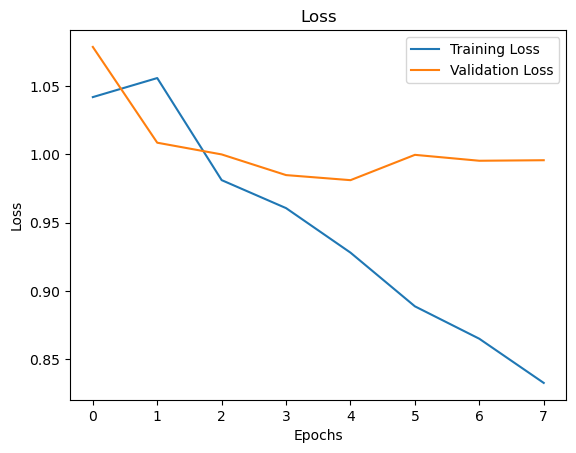

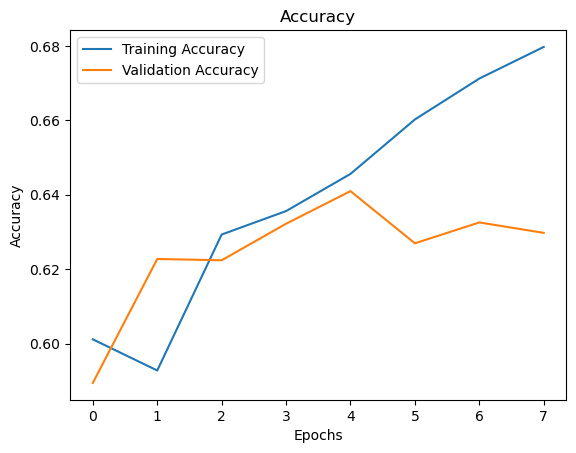

In [32]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model 2: Bidirectional LSTM with Regularization

In [33]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 100, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model2.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model2.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))

model2.build(
    input_shape=(None, X_train.shape[1])
)

# Set new adam with 0.001 learning rate
adam = Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model2.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 145, 100)            │       1,686,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 145, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,086,022 (7.96 MB)

 Trainable params: 399,622 (1.52 MB)

 Non-trainable params: 1,686,400 (6.43 MB)

In [34]:
# Train the model1
history = model2.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    verbose=True,
    batch_size=256,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3659 - loss: 1.6140 - val_accuracy: 0.5126 - val_loss: 1.3301
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 87s 971ms/step - accuracy: 0.4915 - loss: 1.3522 - val_accuracy: 0.5158 - val_loss: 1.2663
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 87s 969ms/step - accuracy: 0.5069 - loss: 1.2797 - val_accuracy: 0.5445 - val_loss: 1.2076
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 88s 978ms/step - accuracy: 0.5326 - loss: 1.2334 - val_accuracy: 0.5701 - val_loss: 1.1567
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 88s 975ms/step - accuracy: 0.5513 - loss: 1.1839 - val_accuracy: 0.5736 - val_loss: 1.1368
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 90s 998ms/step - accuracy: 0.5517 - loss: 1.1841 - val_accuracy: 0.5901 - val_loss: 1.1090
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 89s 992ms/step - accuracy: 0.5657 - loss: 1.1479 - val_accuracy: 0.5894 - val_loss: 1.0992
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 89s 989ms/step - accuracy: 0.5694 - loss: 1.1353 - val_accurac

In [35]:
model2.evaluate(X_val, y_val, verbose=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6278 - loss: 1.0136


[1.0052622556686401, 0.6335904598236084]

In [37]:
predicted = model2.predict(X_test)
y_pred = predicted.argmax(axis=-1)
y_true = le.transform(test_df['sentiment'])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(classification_report(le.transform(test_df['sentiment']), y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
Precision: 0.6290
Recall: 0.6313
F1-Score: 0.6289
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       725
           1       0.59      0.44      0.50       123
           2       0.65      0.66      0.66        98
           3       0.72      0.77      0.75       857
           4       0.61      0.51      0.56       379
           5       0.58      0.58      0.58       677

    accuracy                           0.63      2859
   macro avg       0.62      0.60      0.61      2859
weighted avg       0.63      0.63      0.63      2859



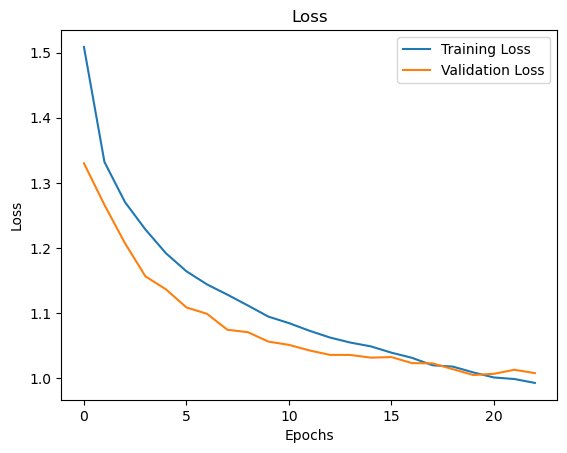

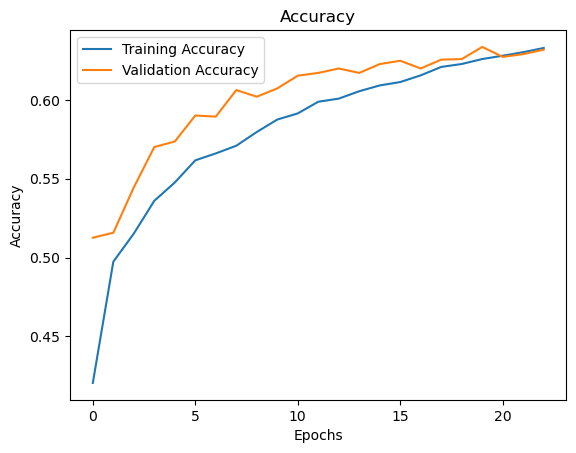

In [38]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model 3: Enhanced LSTM with Additional Dense Layer

In [39]:
# Model 3
model3 = Sequential()
model3.add(Embedding(vocab_size, 100, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=True))
model3.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model3.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) 
model3.add(Dropout(0.3))
model3.add(Dense(num_classes, activation='softmax'))

model3.build(input_shape=(None, X_train.shape[1]))

adam = Adam(learning_rate=0.0001, clipnorm=1.0)
model3.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Print model summary
model3.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 145, 100)            │       1,686,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 145, 512)            │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,090,758 (11.79 MB)

 Trainable params: 3,090,758 (11.79 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train model3
history = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.2729 - loss: 2.6522 - val_accuracy: 0.3745 - val_loss: 2.3615
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4011 - loss: 2.3110 - val_accuracy: 0.4902 - val_loss: 2.0740
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.4645 - loss: 2.0646 - val_accuracy: 0.5238 - val_loss: 1.8971
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4965 - loss: 1.9104 - val_accuracy: 0.5295 - val_loss: 1.7691
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5141 - loss: 1.7898 - val_accuracy: 0.5435 - val_loss: 1.6691
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5328 - loss: 1.6843 - val_accuracy: 0.5491 - val_loss: 1.5871
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5423 - loss: 1.5993 - val_accuracy: 0.5628 - val_loss: 1.5146
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5467 - loss: 1.5263 - val_accuracy: 0.5635 - v

In [41]:
# Evaluate model
model3.evaluate(X_test, y_test, batch_size=32)

90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.6343 - loss: 1.0463


[1.0492819547653198, 0.6264427900314331]

In [42]:
predicted = model3.predict(X_test)
y_pred = predicted.argmax(axis=-1)
y_true = le.transform(test_df['sentiment'])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(classification_report(le.transform(test_df['sentiment']), y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step
Precision: 0.6347
Recall: 0.6264
F1-Score: 0.6254
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       725
           1       0.55      0.33      0.42       123
           2       0.69      0.49      0.57        98
           3       0.77      0.72      0.74       857
           4       0.63      0.49      0.55       379
           5       0.59      0.60      0.60       677

    accuracy                           0.63      2859
   macro avg       0.63      0.55      0.58      2859
weighted avg       0.63      0.63      0.63      2859



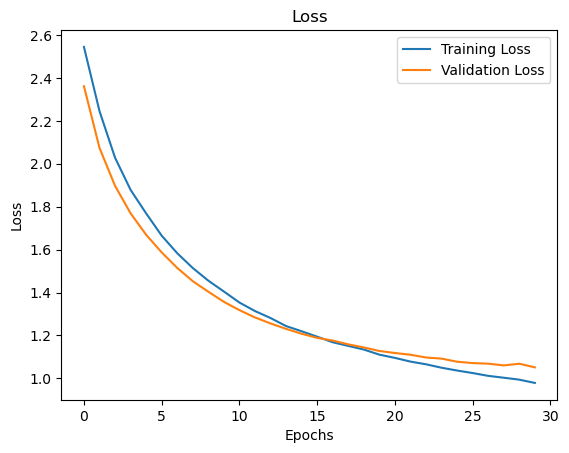

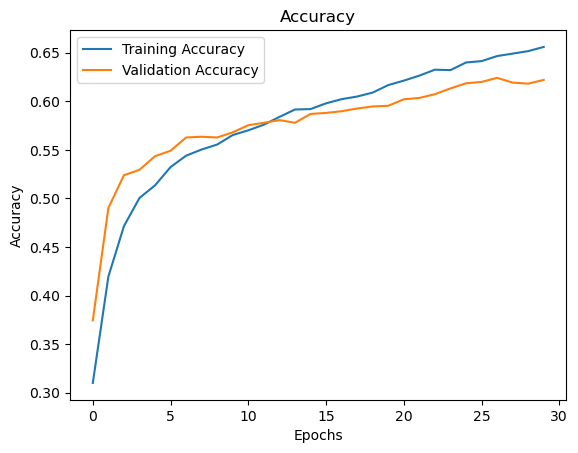

In [43]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model 4: Convolutional LSTM

In [48]:
model4 = Sequential()
model4.add(Embedding(vocab_size, 100, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model4.add(Conv1D(128, 5, activation='relu'))
model4.add(GlobalMaxPooling1D())
model4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

model4.build(input_shape=(None, X_train.shape[1]))

model4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 145, 100)            │       1,686,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 141, 128)            │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,759,174 (6.71 MB)

 Trainable params: 72,774 (284.27 KB)

 Non-trainable params: 1,686,400 (6.43 MB)

In [49]:
# Train the model1
history = model4.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    verbose=True,
    batch_size=256,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.3464 - loss: 2.2929 - val_accuracy: 0.5105 - val_loss: 1.6469
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5049 - loss: 1.5933 - val_accuracy: 0.5501 - val_loss: 1.3771
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5479 - loss: 1.3551 - val_accuracy: 0.5561 - val_loss: 1.2790
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5834 - loss: 1.2272 - val_accuracy: 0.5757 - val_loss: 1.2022
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6104 - loss: 1.1476 - val_accuracy: 0.5761 - val_loss: 1.1743
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.6215 - loss: 1.1014 - val_accuracy: 0.5845 - val_loss: 1.1574
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6422 - loss: 1.0439 - val_accuracy: 0.5908 - val_loss: 1.1450
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6532 - loss: 1.0147 - val_accuracy: 0.5845 - v

In [50]:
model4.evaluate(X_val, y_val, verbose=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5792 - loss: 1.1654


[1.1415339708328247, 0.5932678580284119]

In [51]:
predicted = model4.predict(X_test)
y_pred = predicted.argmax(axis=-1)
y_true = le.transform(test_df['sentiment'])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(classification_report(le.transform(test_df['sentiment']), y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.5837
Recall: 0.5862
F1-Score: 0.5754
              precision    recall  f1-score   support

           0       0.51      0.64      0.56       725
           1       0.49      0.16      0.24       123
           2       0.57      0.33      0.42        98
           3       0.68      0.78      0.72       857
           4       0.57      0.47      0.51       379
           5       0.57      0.47      0.52       677

    accuracy                           0.59      2859
   macro avg       0.56      0.47      0.50      2859
weighted avg       0.58      0.59      0.58      2859



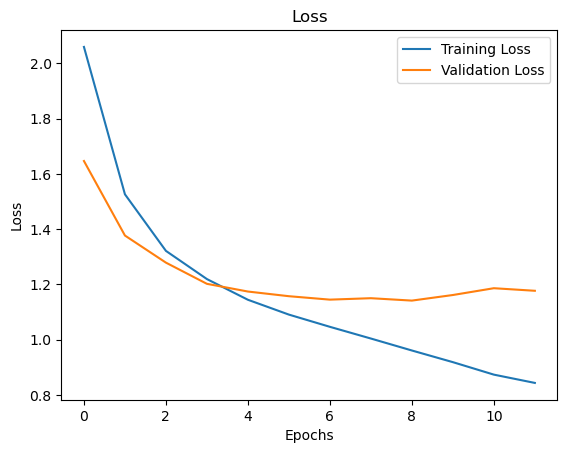

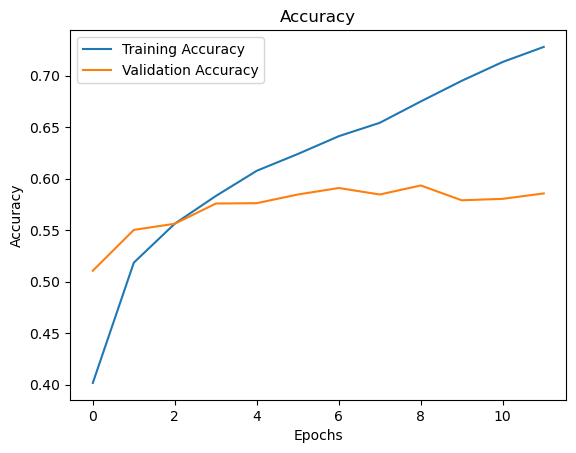

In [52]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model 6: Multi-Head Attention LSTM

In [53]:
input_layer = Input(shape=(X_train.shape[1],))
embedding_layer = Embedding(input_dim=vocab_size,output_dim=100,input_length=X_train.shape[1],weights=[embedding_matrix],trainable=False)(input_layer)
attention_output = MultiHeadAttention(num_heads=4, key_dim=100)(query=embedding_layer,value=embedding_layer,key=embedding_layer)

normalized_output = LayerNormalization()(attention_output + embedding_layer)
pooled_output = GlobalAveragePooling1D()(normalized_output)


dense_output = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(pooled_output)
dropout_output = Dropout(0.5)(dense_output)
output_layer = Dense(num_classes, activation='softmax')(dropout_output)

model6 = Model(inputs=input_layer, outputs=output_layer)


model6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Model summary
model6.summary()

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 145)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_6 (Embedding)       │ (None, 145, 100)          │       1,686,400 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 145, 100)          │         161,300 │ embedding_6[0][0],         │
│ (MultiHeadAttention)          │                           │                 │ embedding_6[0][0],         │
│                               │                           │                 │ embedding_6[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 145, 100)          │               0 │ multi_head_attention[0][0… │
│                               │                           │                 │ embedding_6[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 145, 100)          │             200 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 100)               │               0 │ layer_normalization[0][0]  │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 128)               │          12,928 │ global_average_pooling1d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 128)               │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 6)                 │             774 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,861,602 (7.10 MB)

 Trainable params: 175,202 (684.38 KB)

 Non-trainable params: 1,686,400 (6.43 MB)

In [54]:
# Train the model1
history = model6.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    verbose=True,
    batch_size=256,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 443ms/step - accuracy: 0.3786 - loss: 2.3358 - val_accuracy: 0.5368 - val_loss: 1.5095
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 437ms/step - accuracy: 0.5505 - loss: 1.4309 - val_accuracy: 0.5680 - val_loss: 1.2264
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 439ms/step - accuracy: 0.5747 - loss: 1.2156 - val_accuracy: 0.5961 - val_loss: 1.1123
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 439ms/step - accuracy: 0.5944 - loss: 1.1283 - val_accuracy: 0.6171 - val_loss: 1.0656
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 429ms/step - accuracy: 0.6006 - loss: 1.0853 - val_accuracy: 0.6073 - val_loss: 1.0601
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 430ms/step - accuracy: 0.6098 - loss: 1.0532 - val_accuracy: 0.6140 - val_loss: 1.0427
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 439ms/step - accuracy: 0.6129 - loss: 1.0526 - val_accuracy: 0.6140 - val_loss: 1.0324
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 438ms/step - accuracy: 0.6162 - loss: 1.0361 - val_accu

In [55]:
model6.evaluate(X_val, y_val, verbose=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6100 - loss: 1.0311


[1.0133028030395508, 0.6209677457809448]

In [56]:
predicted = model6.predict(X_test)
y_pred = predicted.argmax(axis=-1)
y_true = le.transform(test_df['sentiment'])

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(classification_report(le.transform(test_df['sentiment']), y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Precision: 0.6152
Recall: 0.6177
F1-Score: 0.6135
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       725
           1       0.63      0.42      0.50       123
           2       0.68      0.64      0.66        98
           3       0.69      0.78      0.73       857
           4       0.55      0.54      0.54       379
           5       0.61      0.51      0.55       677

    accuracy                           0.62      2859
   macro avg       0.62      0.58      0.60      2859
weighted avg       0.62      0.62      0.61      2859



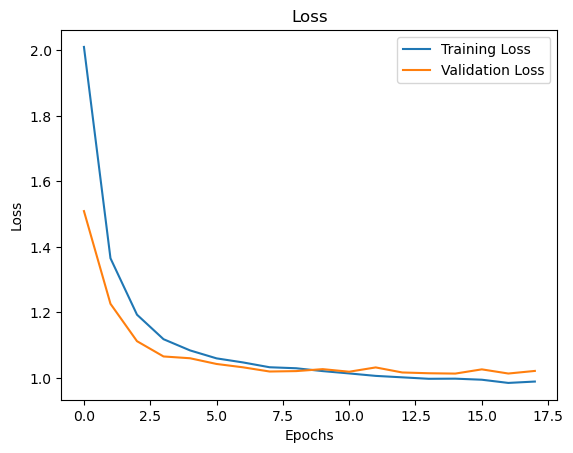

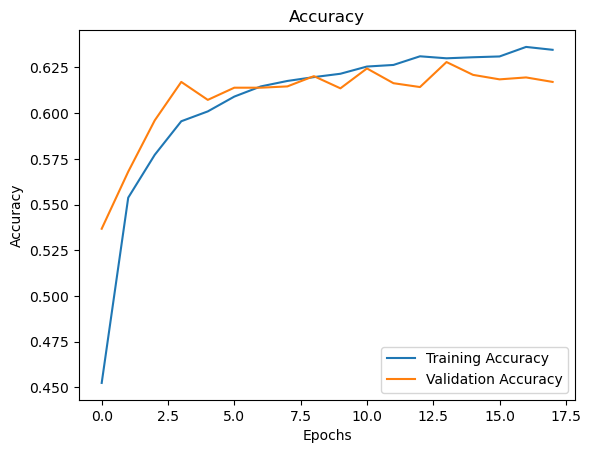

In [57]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Apply k-fold to Model 1

In [60]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Evaluate the model on validation data
    y_val_pred = np.argmax(model1.predict(X_val_fold), axis=1)
    y_val_true = np.argmax(y_val_fold, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_val_true, y_val_pred)
    precision = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val_true, y_val_pred, average='weighted', zero_division=0)

    # Append fold metrics
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)

    print(f"Fold {fold} Results - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

    fold += 1

# Compute overall metrics
print("\n--- Overall Results ---")
print(f"Average Accuracy: {np.mean(fold_accuracies)}")
print(f"Average Precision: {np.mean(fold_precisions)}")
print(f"Average Recall: {np.mean(fold_recalls)}")
print(f"Average F1-Score: {np.mean(fold_f1s)}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step
Fold 1 Results - Accuracy: 0.7054314498466929, Precision: 0.702836590369338, Recall: 0.7054314498466929, F1-Score: 0.702696545928688
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step
Fold 2 Results - Accuracy: 0.7001752080595708, Precision: 0.6980723833669491, Recall: 0.7001752080595708, F1-Score: 0.6979278808835232
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step
Fold 3 Results - Accuracy: 0.6938239159001314, Precision: 0.6908854626512332, Recall: 0.6938239159001314, F1-Score: 0.6909829003033032
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step
Fold 4 Results - Accuracy: 0.6894437144108629, Precision: 0.6869861080754148, Recall: 0.6894437144108629, F1-Score: 0.6875263527713472
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step
Fold 5 Results - Accuracy: 0.6972617743702081, Precision: 0.6948151639058364, Recall: 0.6972617743702081, F1-Score: 0.6951923379824131

--- Overall Results ---
Average Accuracy: 0.6972272125174932
Average Precision: 0.6947191416737543
Average